<a href="https://colab.research.google.com/github/AlexKressner/Vorlesung-Business-Intelligence-Anwendungen/blob/main/Case_Study_Shopify_Barber_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study "Online Barber Shop"
Sie finden bei Moodle den Ausschnitt eines realen Datensatzes einer **Direct-to-Consumer (D2C) Brand**, die über einen Onlineshop **Rasierer** und **Rasierzubehör** verkauft. Für das Unternehmen ist es enorm wichtig, dass es die voraussichtlichen **Absätze der nächsten 21 Tage** kennt, da es Waren im Voraus bei seinen Lieferanten bestellen muss. Je genauer die Absatzprognose, desto weniger Stockouts bzw. unnötige Bestände hat das Unternehmen und desto besser die Marge.

Bisher ist es dem Unternehmen nicht gelungen, gute Prognosen zu erstellen. Um dies zu ändern, werden Sie nun beauftragt, eine Prognose mithilfe von ML-Algorithmen anzufertigen. Dazu stellt Ihnen das Unternehmen einen ersten Datensatz aus seinem Shopsystem zur Verfügung. In diesem sind **3 Produkte** enthalten (Alaunstein, Bartbalm und ein Rasierer) und Sie sollen für diese jeweils eine Absatzprogonse erstellen. Bitte orientieren Sie sich bei der Bearbeitung der Fallstudie an der in diesem Notebook vorgeschlagenen Struktur und greifen Sie auf die Notebooks zurück, die wir bereits in der Vorlesung gemeinsam bearbeitet haben.

# 1 Daten in Google-Drive importieren und in Notebook laden
Bitte achten Sie hier darauf, dass die Datentypen für die Werte in den Spalten geeignet gewählt sind.

In [833]:
from google.colab import output 
output.enable_custom_widget_manager()

In [834]:
import pandas as pd

In [835]:
# Google-Drive einbinden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [836]:
path = "/content/drive/MyDrive/DHBW/BI/Daten/Barber/"

In [837]:
data = pd.read_csv(path+"shopify_data.csv", sep=";", parse_dates=["Datum"])

In [838]:
data.dtypes

Datum           datetime64[ns]
Bestellung              object
Versand Land            object
Versandort              object
Produkt                 object
Nettomenge               int64
Bruttoumsatz           float64
dtype: object

In [839]:
data.head(10)

,Datum,Bestellung,Versand Land,Versandort,Produkt,Nettomenge,Bruttoumsatz
0,2020-01-05,#1005,Germany,Obertshausen,Alaunstein,1,7.55
1,2020-01-05,#1007,Germany,Hellenhahn,Alaunstein,1,7.55
2,2020-01-05,#1008,Germany,Oldenburg,Alaunstein,1,7.55
3,2020-01-05,#1012,Germany,Iserlohn,Alaunstein,1,8.99
4,2020-01-05,#1017,Germany,Buxtehude,Alaunstein,1,7.55
5,2020-02-05,#1021,Germany,Bad Dürkheim An Der Weinstraße,Alaunstein,1,8.99
6,2020-04-05,#1028,Austria,Kufstein,Alaunstein,1,9.99
7,2020-05-05,#1034,Germany,Velbert,Alaunstein,1,8.38
8,2020-07-05,#1045,Germany,Piding,Alaunstein,1,8.39
9,2020-08-05,#1047,Germany,Detmold,Alaunstein,1,8.39


#2 Datenaufbereitung
Sie müssen die täglichen Absätze eines Produktes für die nächsten 21 Tage prognostizieren. Die Daten müssen Sie zu diesem Zweck erst aufbereiten. Denken Sie nochmals an das Kapitel, in dem wir Daten gruppiert haben. Die Gruppierung mussen bei dem vorliegenden Problem auf das Datum **und** Produkt erfolgen (tägliche Produktabsätze).

In [840]:
# mit reset_index() sind Datum und Produkt wieder Spalten des DataFrames,
# der nach der Gruppierung resultiert
absatz_tag = data.groupby(["Datum","Produkt"]).sum().reset_index()

In [841]:
absatz_tag.tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz
1111,2022-12-08,Rasierhobel Solingen Stahl - Set,1,75.62
1112,2022-12-09,Alaunstein,4,33.54
1113,2022-12-09,Bartbalm Crusoe,1,21.00
1114,2022-12-10,Alaunstein,2,16.76
1115,2022-12-10,Rasierhobel Solingen Stahl - Set,1,75.62


# 3 Datenexploration und -visualisierung
Verschaffen Sie sich erst einmal einen Überblick zu den Absatzzahlen (für alle drei Produkte summiert oder je Produkt). Visualisieren Sie beispielsweise den Umsatz über den Zeitverlauf. Erkennen Sie Muster, die typisch für den e-Commerce sind? Wie sieht es mit den Produktpreisen aus? Wurden diese überhaupt variiert und haben diese einen Einfluss auf die Absätze? Achten Sie darauf, dass die Spalte "Bruttoumsatz" nicht gleich dem Produktpreis pro Stück ist!

#### Anzahl Beobachtungen

In [842]:
absatz_tag.groupby(["Produkt"])["Nettomenge"].count()

Produkt
Alaunstein                          801
Bartbalm Crusoe                     203
Rasierhobel Solingen Stahl - Set    112
Name: Nettomenge, dtype: int64

### Umsätze nach Produkt


In [843]:
absatz_tag.groupby(["Produkt"])["Bruttoumsatz"].sum()

Produkt
Alaunstein                          32102.51
Bartbalm Crusoe                      8539.43
Rasierhobel Solingen Stahl - Set    11899.14
Name: Bruttoumsatz, dtype: float64

### Monatliche Nettomenge (Absatz) der Produkte

In [844]:
# Bedarfe pro Woche über alle drei Produkte
# 1. Schritt: Jahr-Monat aus Spalte Datum ableiten
absatz_tag["Jahr-Monat"] = absatz_tag.Datum.dt.to_period("M")

In [845]:
# 2. Schritt: Bruttoumsatz auf Monatsscheiben aggregieren
monatsumsaetze = absatz_tag.groupby(["Produkt","Jahr-Monat"])["Nettomenge"].sum().reset_index()

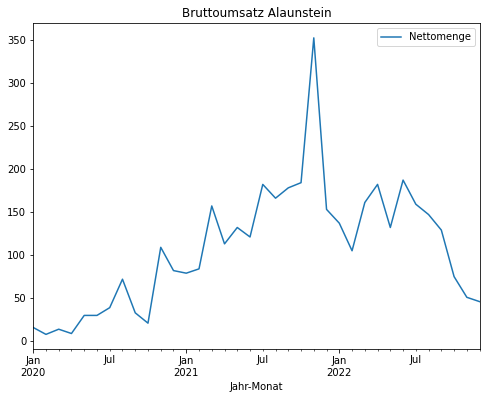

In [846]:
# 3. Schritt: Bruttoumsatz eines Produktes abbilden
monatsumsaetze[monatsumsaetze.Produkt=="Alaunstein"].plot(kind="line", x="Jahr-Monat", y="Nettomenge", figsize=(8,6), title="Bruttoumsatz Alaunstein")

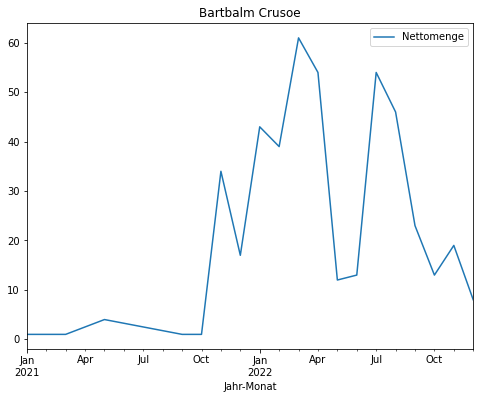

In [847]:
monatsumsaetze[monatsumsaetze.Produkt=="Bartbalm Crusoe"].plot(kind="line", x="Jahr-Monat", y="Nettomenge", figsize=(8,6), title="Bartbalm Crusoe")

#### Darstellung der Nettomengen je Produkt in einer Abbildung

In [848]:
import matplotlib.pyplot as plt
# alle Bruttoumsätze in einer Abbildung
# 1. Schritt: Spalte zum Index machen (x-Achse)
monatsumsaetze.set_index("Jahr-Monat", inplace=True)

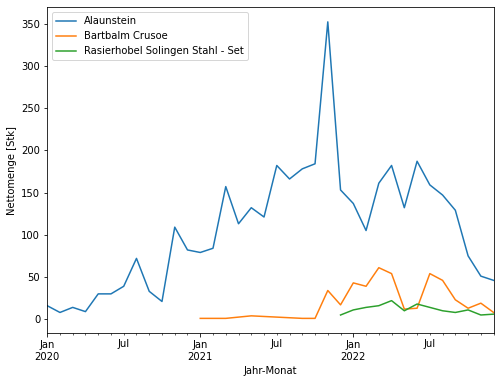

In [849]:
# 2. Schritt: Erzeugen des Abbildungsobjektes
fig, ax = plt.subplots(figsize=(8,6))
# 3. Schritt: Jeweiliges gruppieren auf Produkte und Übergabe des Abbildungsobjektes "ax=ax"
for label, df in monatsumsaetze.groupby('Produkt'):
    df["Nettomenge"].plot(
        kind="line", 
        ax=ax, 
        label=label,
        ylabel="Nettomenge [Stk]"
        )
plt.legend()

### Umsatz und Nettomenge

#### Nach Monat

In [850]:
absatz_tag["Monat"] = absatz_tag.Datum.dt.month 

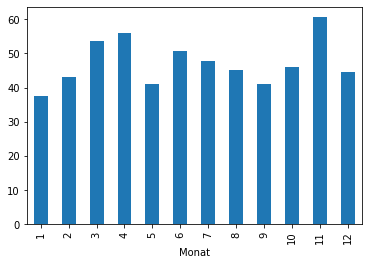

In [851]:
absatz_tag.groupby("Monat")["Bruttoumsatz"].mean().plot(kind = "bar")

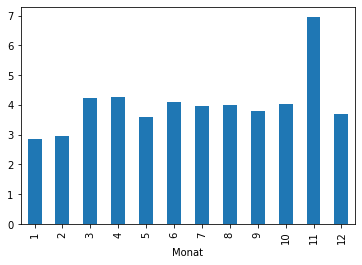

In [852]:
absatz_tag.groupby("Monat")["Nettomenge"].mean().plot(kind = "bar")

#### Nach Woche

In [853]:
absatz_tag["Woche"] = absatz_tag.Datum.dt.week 

<ipython-input-853-84719c409297>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  absatz_tag["Woche"] = absatz_tag.Datum.dt.week


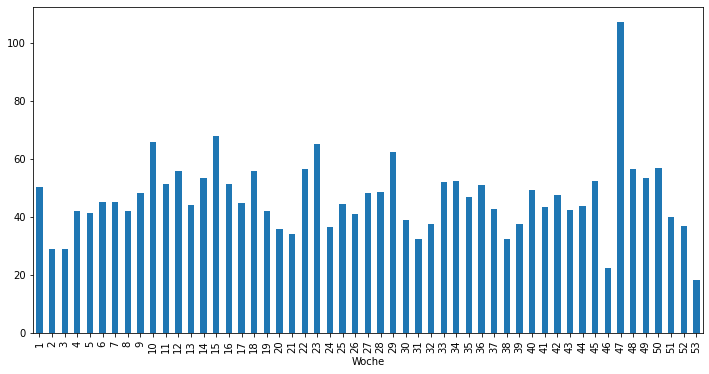

In [854]:
absatz_tag.groupby("Woche")["Bruttoumsatz"].mean().plot(kind = "bar", figsize=(12,6))

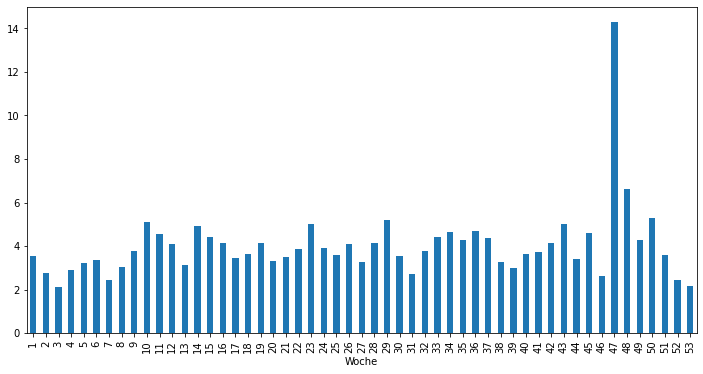

In [855]:
absatz_tag.groupby("Woche")["Nettomenge"].mean().plot(kind = "bar", figsize=(12,6))

#### Nach Wochentag

In [856]:
absatz_tag["Wochentag"] = absatz_tag.Datum.dt.weekday

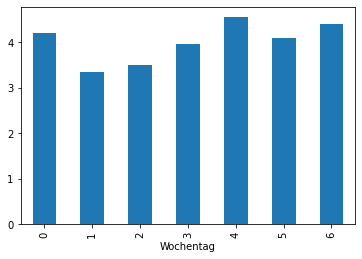

In [857]:
absatz_tag.groupby("Wochentag")["Nettomenge"].mean().plot(kind = "bar")

### Stückpreis und Absatz nach Woche

In [858]:
absatz_tag["Stueckpreis"] = absatz_tag["Bruttoumsatz"] / absatz_tag["Nettomenge"]

In [859]:
absatz_tag["Jahr-Woche"] = absatz_tag["Datum"].dt.to_period("W")

In [860]:
absatz_tag.Produkt.unique()

array(['Alaunstein', 'Bartbalm Crusoe',
       'Rasierhobel Solingen Stahl - Set'], dtype=object)

In [861]:
produkt = "Alaunstein"

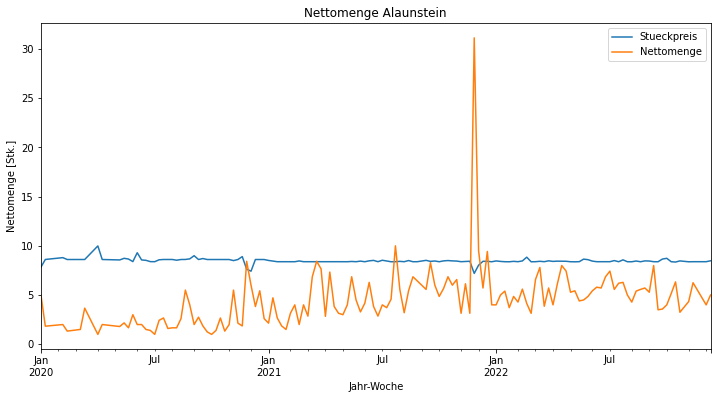

In [862]:
fig, ax = plt.subplots(figsize=(12,6))
absatz_tag[absatz_tag.Produkt==produkt].groupby("Jahr-Woche")["Stueckpreis"].mean().plot(kind="line", ax=ax)
absatz_tag[absatz_tag.Produkt==produkt].groupby("Jahr-Woche")["Nettomenge"].mean().plot(kind="line", ax=ax, title=f"Nettomenge {produkt}", ylabel="Nettomenge [Stk.]")
plt.legend()

# 4 Feature Engineering
Beim Feature Engineering versucht man weitere Merkmale aus den gegebenen Grunddaten abzuleiten, die bei der Prognose hilfreich sein können. Im vorliegenden Fall bietet es sich beispielsweise an **zeitlichen** und **preislichen Features** abzuleiten.

**Zeitliche Features**: Zum Beispiel können wir aus dem Datum die Woche oder den Monat entnehmen. Dies ergibt Sinn, wenn wir vermuten, dass der Monat/ die Woche einen Einfluss auf die Höhe der Absätze hat. Ebenso vorstellbar ist es, eine Trendvariable einzuführen (vgl. Notebook aus der Veranstaltung), die das durchschnittlicher Absatzwachstum des Shops über die Zeit erfasst.

**Preisliche Features**: Wir sollten vermutlich den Produktpreis als Feature verwenden. Außerdem könnte es interessant sein, den durchschnittlichen Produktpreis der letzten x-Wochen als Feature zu berücksichtigen, oder die individuellen Preise der letzten x-Wochen.

In [863]:
# aktuelle Spalten (Features)
absatz_tag.columns

Index(['Datum', 'Produkt', 'Nettomenge', 'Bruttoumsatz', 'Jahr-Monat', 'Monat',
       'Woche', 'Wochentag', 'Stueckpreis', 'Jahr-Woche'],
      dtype='object')

In [864]:
# Weitere preisliche Features
absatz_tag["Preismomentum"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.median() - x)
absatz_tag["Preis_rolling_1"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(1).rolling(1).mean())
absatz_tag["Preis_rolling_3"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(1).rolling(3).mean())
absatz_tag["Preis_rolling_5"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(1).rolling(5).mean())
absatz_tag["Preis_rolling_10"] = absatz_tag.groupby("Produkt")["Stueckpreis"].transform(lambda x: x.shift(1).rolling(10).mean())
# es gäbe noch viele mehr

In [865]:
absatz_tag.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Jahr-Monat,Monat,Woche,Wochentag,Stueckpreis,Jahr-Woche,Preismomentum,Preis_rolling_1,Preis_rolling_3,Preis_rolling_5,Preis_rolling_10
0,2020-01-05,Alaunstein,5,39.19,2020-01,1,1,6,7.838000,2019-12-30/2020-01-05,0.552000,NaN,NaN,NaN,NaN
1,2020-01-07,Alaunstein,1,8.62,2020-01,1,2,1,8.620000,2020-01-06/2020-01-12,-0.230000,7.838000,NaN,NaN,NaN
2,2020-01-08,Alaunstein,1,8.62,2020-01,1,2,2,8.620000,2020-01-06/2020-01-12,-0.230000,8.620000,NaN,NaN,NaN
3,2020-01-09,Alaunstein,3,25.85,2020-01,1,2,3,8.616667,2020-01-06/2020-01-12,-0.226667,8.620000,8.359333,NaN,NaN
4,2020-01-10,Alaunstein,1,8.61,2020-01,1,2,4,8.610000,2020-01-06/2020-01-12,-0.220000,8.616667,8.618889,NaN,NaN


In [866]:
absatz_tag.dropna(inplace=True)

In [867]:
absatz_tag.columns

Index(['Datum', 'Produkt', 'Nettomenge', 'Bruttoumsatz', 'Jahr-Monat', 'Monat',
       'Woche', 'Wochentag', 'Stueckpreis', 'Jahr-Woche', 'Preismomentum',
       'Preis_rolling_1', 'Preis_rolling_3', 'Preis_rolling_5',
       'Preis_rolling_10'],
      dtype='object')

In [868]:
FEATURES = [
    "Produkt","Monat","Woche","Wochentag", "Stueckpreis",
    'Preismomentum', 'Preis_rolling_5', 'Preis_rolling_10', 
    'Preis_rolling_1', 'Preis_rolling_3',
    ]

In [869]:
TARGET = "Nettomenge"

# 5 Prognosemodell trainieren und bewerten
Versuchen Sie ein Modell auf die Daten zu trainieren. Testen Sie verschiedene Modellparameter mithilfe einer Grid Search und Cross-Validation.

### 5.1 Produkte als Feature (Ein Prognosemodell für alle Produkte)

In [804]:
# Features und target
X = absatz_tag[FEATURES]
y = absatz_tag[TARGET]

In [805]:
X = pd.get_dummies(X)

In [806]:
X.head()

,Monat,Woche,Wochentag,Stueckpreis,Preismomentum,Preis_rolling_5,Preis_rolling_10,Preis_rolling_1,Preis_rolling_3,Produkt_Alaunstein,Produkt_Bartbalm Crusoe,Produkt_Rasierhobel Solingen Stahl - Set
10,2,7,1,8.610,-0.220,8.686,8.573467,8.610,8.736667,1,0,0
11,2,7,2,8.610,-0.220,8.686,8.650667,8.610,8.610000,1,0,0
12,3,10,5,8.615,-0.225,8.686,8.649667,8.610,8.610000,1,0,0
13,3,10,6,8.620,-0.230,8.611,8.649167,8.615,8.611667,1,0,0
14,3,11,0,8.615,-0.225,8.613,8.649500,8.620,8.615000,1,0,0


In [807]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

In [808]:
# Grid definieren
param_grid = {
    "n_estimators": [50, 150, 250, 500] # Anzahl der Entscheidungsbäume
}

In [809]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Modell auswählen und trainieren
model = RandomForestRegressor()
grid = GridSearchCV(
    model, # verwendetes Modell
    param_grid, # zu untersuchende Parameter
    cv=10, # Anzahl der Folds
    n_jobs=-1, # Parallelisierung der Ausführung
    scoring="neg_mean_squared_error", # Fehlermaß
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
# Prognosen machen (y_pred)
y_pred = best_model.predict(X_test)
# Modell evaluieren
sklearn.metrics.mean_absolute_error(y_test, y_pred)

1.5632018348623855

### 5.2. Ein Modell je Produkt

In [761]:
ergebnis = {}
for produkt in absatz_tag.Produkt.unique():
  X = absatz_tag.loc[absatz_tag.Produkt==produkt, FEATURES].drop(columns=["Produkt"])
  y = absatz_tag.loc[absatz_tag.Produkt==produkt, TARGET]
  X = pd.get_dummies(X)

  # Grid definieren
  param_grid = {
      "n_estimators": [50, 150, 250, 500] # Anzahl der Entscheidungsbäume
  }
  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
  # Modell auswählen und trainieren
  model = RandomForestRegressor()
  grid = GridSearchCV(
      model, # verwendetes Modell
      param_grid, # zu untersuchende Parameter
      cv=10, # Anzahl der Folds
      n_jobs=-1, # Parallelisierung der Ausführung
      scoring="neg_mean_squared_error", # Fehlermaß
  )
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  # Prognosen machen (y_pred)
  y_pred = best_model.predict(X_test)
  # Modell evaluieren
  ergebnis[produkt] = sklearn.metrics.mean_absolute_error(y_test, y_pred)

In [762]:
ergebnis

{'Alaunstein': 2.2306415094339624,
 'Bartbalm Crusoe': 1.020102564102564,
 'Rasierhobel Solingen Stahl - Set': 0.37657142857142856}

# 6 Prognosemodell unter Berücksichtigung der Zeitreiheneigenschaft

In [882]:
absatz_tag.sort_values(by="Datum", inplace=True)

In [902]:
absolut_error = {}
absolut_percentage_error = {}
for produkt in absatz_tag.Produkt.unique():
  # 1. Schritt: Daten auf Produkt filtern
  X = absatz_tag.loc[absatz_tag.Produkt==produkt, FEATURES].drop(columns="Produkt")
  y = absatz_tag.loc[absatz_tag.Produkt==produkt, TARGET]

  # 2. Schritt: Daten umwandeln
  X = pd.get_dummies(X)
  
  # 3. Schritt: Zeitlicher Split (Prognose für die nächsten 21 Tage)
  X_train = X[:-21]
  y_train = y[:-21]
  X_test = X[-21:]
  y_test = y[-21:]

  # Grid definieren
  param_grid = {
      "n_estimators": [50, 150, 250, 500] # Anzahl der Entscheidungsbäume
  }
  # Modell auswählen und trainieren
  model = RandomForestRegressor()
  grid = GridSearchCV(
      model, # verwendetes Modell
      param_grid, # zu untersuchende Parameter
      cv=10, # Anzahl der Folds
      n_jobs=-1, # Parallelisierung der Ausführung
      scoring="neg_mean_squared_error", # Fehlermaß
  )
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  # Prognosen machen (y_pred)
  y_pred = best_model.predict(X_test)
  # Ergebnisse für 21 Tage Nettomenge summiert
  absolut_error[produkt] = abs(y_test.sum() - y_pred.sum())
  absolut_percentage_error[produkt] = abs(y_test.sum() - y_pred.sum())/y_test.sum() * 100

In [903]:
absolut_error

{'Alaunstein': 8.75333333333333,
 'Bartbalm Crusoe': 11.14,
 'Rasierhobel Solingen Stahl - Set': 1.806000000000001}

In [905]:
absolut_percentage_error

{'Alaunstein': 8.581699346405227,
 'Bartbalm Crusoe': 25.318181818181817,
 'Rasierhobel Solingen Stahl - Set': 7.224000000000004}